In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import snap
import matplotlib.pyplot as plt
import math

In [2]:
def groupDf(df):
    return df[1].value_counts()

In [3]:
clusterCount = Counter()
row = 0
chunksize = 10000000
otc_cluster = "otc_scores_with_cluster.csv"
df = pd.read_csv(otc_cluster)

In [4]:
otc_dic = "otc_scores_dict.csv"
dicDf = pd.read_csv(otc_dic, header=None)

In [5]:
scoreDic = dicDf.set_index(0).to_dict()[1]

In [6]:
addrDf = df["address"].apply(lambda a: scoreDic.get(a,0))
df['score'] = addrDf

In [7]:
newdf = df[['cluster_id','score']].groupby('cluster_id').count()

In [8]:
df[df['address'] == "15Nw383QHazR8TtSj2wFvLTLFiCMBpqWXE"]

,cluster_size,cluster_id,address_id,address_type,address,address_num,score
497,291,1558677,5911030,pubkeyhash,15Nw383QHazR8TtSj2wFvLTLFiCMBpqWXE,5911030,-9


In [9]:
clusterScoreDf = df[['cluster_id','score']].groupby('cluster_id').mean()
clusterScoreDict = clusterScoreDf.to_dict()['score']
# Map from cluster to 
clusterScoreDict = Counter(clusterScoreDict)

In [10]:
'''graph = snap.LoadEdgeList(snap.PNGraph, "cluster_links_without_0.csv", 0, 1, ',')
graph = snap.LoadEdgeList(snap.PNGraph, "transactions_from_interesting_users.csv", 0, 1, ',')
triads = snap.GetTriads(graph)'''

'graph = snap.LoadEdgeList(snap.PNGraph, "cluster_links_without_0.csv", 0, 1, \',\')\ngraph = snap.LoadEdgeList(snap.PNGraph, "transactions_from_interesting_users.csv", 0, 1, \',\')\ntriads = snap.GetTriads(graph)'

In [11]:
without_zero_cluster = "cluster_links_without_0.csv"
wzdf = pd.read_csv(without_zero_cluster, header=None)

In [12]:
graph = snap.LoadEdgeList(snap.PNGraph, "transactions_from_interesting_users_v2.csv", 0, 1, ',') #combined_links_without_0_and_interest.csv

In [14]:
negativeNodes = [i for i in clusterScoreDict if clusterScoreDict[i] < 0]

In [15]:
print(len(negativeNodes))

174


In [16]:
outNodeCounter = Counter({})
for node in negativeNodes:
    outNodeCounter[node] += 1
lastLen = 0

iterations = 0
while(lastLen < len(outNodeCounter)):
    iterations += 1
    lastLen = len(outNodeCounter)
    for node in outNodeCounter.keys():
        if node != 0:
            if graph.IsNode(node):
                outNodes = [i for i in graph.GetNI(node).GetOutEdges()]
                for i in outNodes:
                    outNodeCounter[i] += 1
            else:
                print('not_found')
                
print("iterations : %d" % iterations)

iterations : 4


In [17]:
suspiciousClusters = []
for node in outNodeCounter:
    if outNodeCounter[node] > iterations:
        suspiciousClusters.append(node)
print(len(suspiciousClusters))
differentClusters = []
for node in suspiciousClusters:
    if node not in clusterScoreDict:
        differentClusters.append(node)
        
print(differentClusters)

for i in differentClusters:
    print(outNodeCounter[i])
        

40
[1563744, 1871384, 1659131, 1946245]
7
7
7
5


In [18]:
for node in suspiciousClusters:
    print node, (outNodeCounter[node]*1.0/graph.GetNI(node).GetInDeg())

0 0.0144241776692
1424929 0.227272727273
1563744 2.33333333333
1525819 1.25
3171424 2.5
1739958 0.555555555556
1315920 1.0
1251940 2.5
1497702 1.66666666667
1219694 0.625
2420337 2.5
1896079 0.833333333333
1871384 2.33333333333
1558677 0.324324324324
1703600 2.5
372403 2.5
1457695 1.25
1768133 0.714285714286
1580755 1.8
1659131 2.33333333333
2088704 2.5
1813764 1.6
1946245 2.5
1164597 0.16
1619261 0.238095238095
2178375 2.5
2215247 0.714285714286
1868649 0.833333333333
1602877 0.416666666667
1648500 1.25
535932 0.714285714286
1586053 1.66666666667
1458092 1.0
1536960 0.3125
566722 0.138888888889
1607619 0.714285714286
1578437 2.5
1995232 2.5
1922027 0.416666666667
1831923 1.66666666667


In [19]:
snap.PlotInDegDistr(graph, "indeg_combined", "Directed graph - in-degree Distribution")

In [20]:
snap.PlotOutDegDistr(graph, "outdeg_combined", "Directed graph - out-degree Distribution")

In [21]:
snap.PlotClustCf(graph, "clust_coeff_combined", "Directed graph - cluster coefficient")

In [22]:
without_zero_graph = snap.LoadEdgeList(snap.PNGraph, "cluster_links_without_0.csv", 0, 1, ',')
PRankH = snap.TIntFltH()
snap.GetPageRank(without_zero_graph, PRankH)

In [23]:
PRankH.SortByDat()
prankDict = {}
i = 0
for item in PRankH:
    prankDict[item] = PRankH[item]

In [24]:
sortedPrank = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)

In [25]:
# Page rank on clouster links without 0
def pageRankCalculate(graph, title="all non-zero clusters"):
    topIds = []
    for c in [0.01, 0.1, 0.5, 0.9, 0.99, 1.0]:
        PRankH = snap.TIntFltH()
        snap.GetPageRank(graph, PRankH, c)
        prankDict = {}
        for item in PRankH:
            prankDict[item] = PRankH[item]
        sortedPrank = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
        plt.plot([i[1] for i in sortedPrank], [i/float(len(sortedPrank)) for i in range(len(sortedPrank))], label="Damping Factor %f" % c)
        topIds.extend([i[0] for i in sortedPrank[0:20]])
    newlist = []
    for i in topIds:
        if i not in newlist:
            newlist.append(i)
    print(newlist)
    plt.title('Page Rank Distribution on %s' % title)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Page Rank')
    plt.ylabel('CDF')
    plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
    plt.show()
    
def pageRankRegress(graph):
    PRankH = snap.TIntFltH()
    snap.GetPageRank(without_zero_graph, PRankH)
    prankDict = {}
    for item in PRankH:
        prankDict[item] = PRankH[item]
    sortedPrank = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
    plt.plot([i[1] for i in sortedPrank], [i/float(len(sortedPrank)) for i in range(len(sortedPrank))], label="Page Rank")
    # Entire cluster
    x = [i[1] for i in sortedPrank]
    y = [(i+1)/float(len(sortedPrank)) for i in range(len(sortedPrank))]
    logx = np.log(x)
    logy = np.log(y)
    p = np.polyfit(logx,logy, 1)
    a = -1.0 * p[0]
    print("[Full] The value of a is %f" % a)
    lineX = [min(x), max(x)]
    lineY = np.exp([p[1]+p[0]*min(logx), p[1]+p[0]*max(logx)])
    plt.plot(lineX, lineY, label ="Full LSE", color = "g")
    plt.title('Page Rank Distribution on all non-zero clusters')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Page Rank')
    plt.ylabel('CDF')
    plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
    plt.show()

[87966336, 127783720, 391151, 4173414, 5967771, 127198065, 4177844, 4175767, 99524217, 8165960, 482495, 4177151, 354066, 715027, 263554, 5399237, 3736737, 4174618, 336366, 4171988, 144767942, 413141, 403145, 136304180, 2690704, 493743, 1029416, 136709175, 4140240, 279117, 727737, 451773, 4615131, 466522, 4376229]


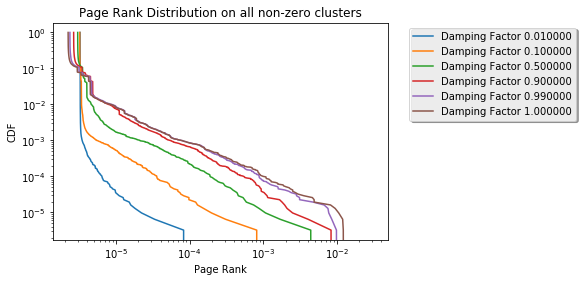

In [26]:
pageRankCalculate(without_zero_graph)

[Full] The value of a is 3.456373


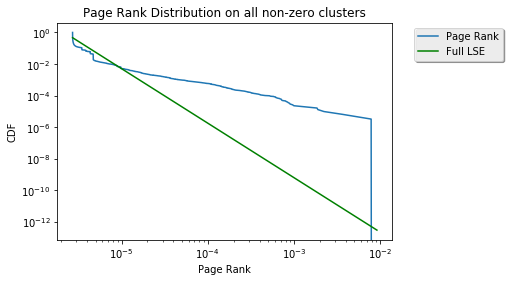

In [27]:
# http://chato.cl/papers/becchetti_06_distribution_pagerank_power_law_particular_damping_factor.pdf
pageRankRegress(without_zero_graph)

[Full] The value of a is 0.186963
[Tail] The value of a is 0.853879


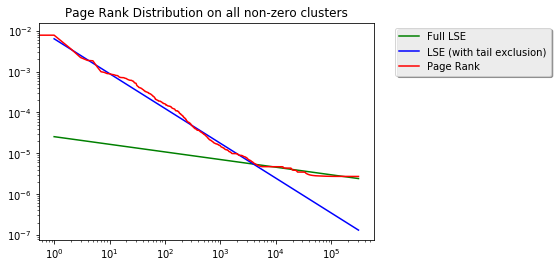

In [28]:
# Entire cluster
x = [i+1 for i in range(len(sortedPrank))]
y = [i[1] for i in sortedPrank]
logx = np.log(x)
logy = np.log(y)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("[Full] The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(logx)])
plt.plot(lineX, lineY, label ="Full LSE", color = "g")

xnew = [i+1 for i in range(4000)]
ynew = [i[1] for i in sortedPrank[0:len(xnew)]]
logx = np.log(xnew)
logy = np.log(ynew)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("[Tail] The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(np.log(x))])
plt.plot(lineX, lineY, label ="LSE (with tail exclusion)", color = "b")

plt.plot([i for i in range(len(sortedPrank))], [i[1] for i in sortedPrank], color="r", label="Page Rank")
    
plt.title('Page Rank Distribution on all non-zero clusters')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
plt.show()

# Page rank dampening -- different results from what we see here
# No truncation
# https://dl.acm.org/citation.cfm?doid=1135777.1135955

In [29]:
print(graph.GetNodes(), graph.GetEdges())

(785198, 1439772)


In [30]:
Graph = snap.GenRndGnm(snap.PNGraph, graph.GetNodes(), graph.GetEdges())
PRankH = snap.TIntFltH()
snap.GetPageRank(Graph, PRankH)
randGraph = Graph
PRankH.SortByDat()
prankDict = {}
i = 0
for item in PRankH:
    prankDict[item] = PRankH[item]
sortedPrankRandom = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)

The value of a is 0.635267


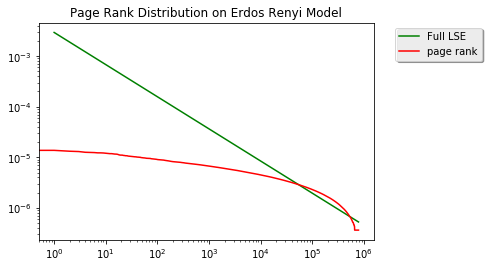

In [31]:
# Page rank on cluster links without 0

# Entire cluster
x = [i+1 for i in range(len(sortedPrankRandom))]
y = [i[1] for i in sortedPrankRandom]
logx = np.log(x)
logy = np.log(y)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(logx)])
plt.plot(lineX, lineY, label ="Full LSE", color = "g")

'''xnew = [i+1 for i in range(4000)]
ynew = [i[1] for i in sortedPrank[0:len(xnew)]]
logx = np.log(xnew)
logy = np.log(ynew)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(np.log(x))])
plt.plot(lineX, lineY, label ="LSE (with tail exclusion)", color = "g")'''

plt.plot([i for i in range(len(sortedPrankRandom))], [i[1] for i in sortedPrankRandom], color="r", label="page rank")
    
plt.title('Page Rank Distribution on Erdos Renyi Model')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
plt.show()

[405397, 461621, 607859, 369793, 62095, 125423, 670631, 275175, 264255, 464707, 40029, 347262, 591949, 259664, 508423, 454171, 114568, 412165, 344813, 603508, 398127, 383007, 380782, 105712, 748655, 261969, 711324, 563452, 421913, 483702, 249791, 204750, 331135, 487875, 773396, 26228, 550145, 648263, 112077, 650886, 574665, 267397, 196588, 471532, 766216, 57628, 368370, 479281, 404855, 408446, 96206, 161229, 758272, 160963, 20236, 96005, 538074, 443109]


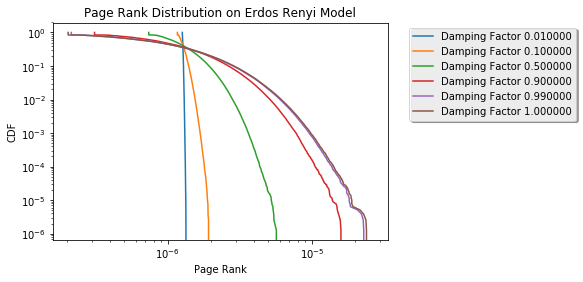

In [32]:
pageRankCalculate(randGraph, title="Erdos Renyi Model")

In [33]:
Rnd = snap.TRnd()
Graph = snap.GenPrefAttach(100, 10, Rnd)
prefAttachedGraph = Graph
PRankH = snap.TIntFltH()
snap.GetPageRank(Graph, PRankH)
PRankH.SortByDat()
prankDict = {}
i = 0
for item in PRankH:
    prankDict[item] = PRankH[item]
sortedPrankRandom = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)

[9, 3, 7, 2, 0, 4, 5, 8, 6, 1, 16, 15, 11, 17, 23, 14, 39, 19, 32, 26, 10, 13, 12]


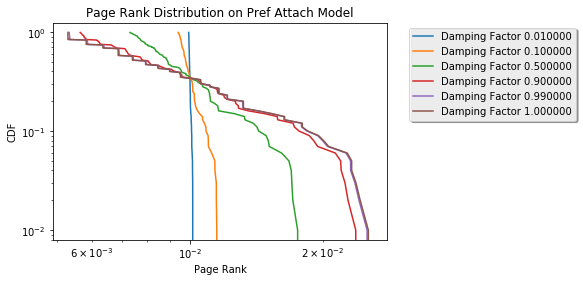

In [34]:
pageRankCalculate(prefAttachedGraph, title="Pref Attach Model")

The value of a is 0.411753


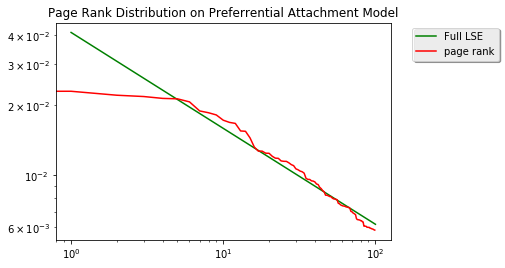

In [35]:
# Page rank on cluster links without 0

# Entire cluster
x = [i+1 for i in range(len(sortedPrankRandom))]
y = [i[1] for i in sortedPrankRandom]
logx = np.log(x)
logy = np.log(y)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(logx)])
plt.plot(lineX, lineY, label ="Full LSE", color = "g")

'''xnew = [i+1 for i in range(4000)]
ynew = [i[1] for i in sortedPrank[0:len(xnew)]]
logx = np.log(xnew)
logy = np.log(ynew)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(np.log(x))])
plt.plot(lineX, lineY, label ="LSE (with tail exclusion)", color = "g")'''

plt.plot([i for i in range(len(sortedPrankRandom))], [i[1] for i in sortedPrankRandom], color="r", label="page rank")
    
plt.title('Page Rank Distribution on Preferrential Attachment Model')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
plt.show()